In [232]:
# from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

from scipy.ndimage import morphology

import random
from itertools import islice

In [233]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [6]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [234]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        preprocessing_function = random_gaussian_noise)

def random_gaussian_noise(image):
    apply_gaussian_noise = random.choice([True, False])
    if apply_gaussian_noise == True:
        output_image = noisy(image)
    else:
        output_image = image
    return output_img
    

def noisy(image):
    ch, row, col = image.shape
    mean = 0
    sigma = np.random.uniform(low=0.0, high=sigma_max, size=None)
    gauss = np.random.normal(mean, sigma, (ch, row,col))
    gauss = gauss.reshape(ch, row,col)
    noisy = image + gauss
    return noisy


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [235]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    x = GaussianNoise(noise)(inputs)
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [236]:
def save_parameters(timestamp, params):
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

## Score measure

In [237]:
## Score measure

def jaccard_score(seg, gt):
    intersection = (seg*gt).sum()
    union = seg.sum()+gt.sum()-intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(pred, gt):
    d1 = morphology.distance_transform_edt(1-gt)*pred
    d2 = morphology.distance_transform_edt(1-pred)*gt
    return d1, d2


def numeric_score(y_pred, y_true):
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    # PPV
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    # TPR, sensitivity
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 



In [238]:
## Rank the most uncertain predictions

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]


## Active Learing loop

In [239]:
def save_history(history, timestamp, iteration, history_path):
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()
    
def scores(model, X_test, y_test, score_global ):
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], 0.6, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        uncertain[i] = compute_uncertain(sample, sample_prediction, model)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    
    return score_global


def uncertainty_for_ranking(model, X_set):
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], 0.6, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        uncertainty[i] = compute_uncertain(sample, sample_prediction, model)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)
    uncertain_map_array = np.asarray(uncertain_map)
    return uncertainty, uncertain_map, predictions

In [241]:
data_path = '../data/'
param_path = '../params/'

# PATH definition
checkpoint_weights_path = "./models/checkpoint_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"
intermediate_weights_path = "./models/intermediate_weights_batch_norm.hdf5"

path_img = '../data/full_images.npy'
path_mask = '../data/full_masks.npy'
history_path = '../history/'


# imag  e dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.3
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

sigma_max = 0.5
noise = 0.5


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training
nb_initial_epochs = 300
apply_augmentation = True
nb_step_predictions = 100
steps_per_epoch = 20
dropout_proba = 0.3

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

apply_edt = False


In [ ]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )

# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0 = X_full[:30]
y_labelled_0 = y_full[:30]

X_unlabelled_0 = X_full[30:80]
y_unlabelled_0 = y_full[30:80]

X_test = X_full[80:]
y_test = y_full[80:]

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")


# START ACTIVE LEARNING ITERATION
for i in range(4):
    model_path = "./models/AL_model_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert
        index = to_be_annotated(uncertain_unlabelled, 10)

        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled, X_unlabelled, index)
        y_labelled = add_annotated_sample(y_labelled, y_unlabelled, index)

        # remove them + masks from test set
        X_unlabelled = remove_annotated(X_unlabelled, index)
        y_unlabelled = remove_annotated(y_unlabelled, index)
        
        print("new_X_train shape = ", X_labelled.shape, "new_y_train shape =", y_labelled.shape)
        print("new_X_test shape=", X_unlabelled.shape, "new_y_test shape =", y_unlabelled.shape)
        
    # train - validation split
    split_index = int(len(X_labelled)*0.80)
    X_valid = X_labelled[split_index:]
    y_valid = y_labelled[split_index:]
    X_labelled = X_labelled[:split_index]
    y_labelled = y_labelled[:split_index]
    print("new_X_train shape = ", X_labelled.shape, "new_y_train shape =", y_labelled.shape)
    print("new_X_valid shape = ", X_valid.shape, "new_y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_labelled, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_labelled, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp))) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    


Loading data...

('X_labelled shape = ', (30, 1, 512, 512), 'X_unlabelled shape = ', (50, 1, 512, 512), 'X_test shape = ', (18, 1, 512, 512))
------------DATA LOADING DONE---------
('------------Starting AL Iteration:', 0, '----------')
('new_X_train shape = ', (24, 1, 512, 512), 'new_y_train shape =', (24, 1, 512, 512))
('new_X_valid shape = ', (6, 1, 512, 512), 'new_y_valid shape =', (6, 1, 512, 512))
------------Starting training -----------
Epoch 1/300
20/20 [==============================] - 10s 476ms/step - loss: 0.2893 - dice_coef: 0.6147 - val_loss: 2.0476 - val_dice_coef: 0.2690
Epoch 2/300
20/20 [==============================] - 9s 426ms/step - loss: 0.2326 - dice_coef: 0.6556 - val_loss: 1.2115 - val_dice_coef: 0.2107
Epoch 3/300
20/20 [==============================] - 9s 425ms/step - loss: 0.2197 - dice_coef: 0.6562 - val_loss: 0.9911 - val_dice_coef: 0.1085
Epoch 4/300
20/20 [==============================] - 8s 424ms/step - loss: 0.2113 - dice_coef: 0.6593 - val_loss: 

20/20 [==============================] - 8s 423ms/step - loss: 0.1369 - dice_coef: 0.7751 - val_loss: 0.1839 - val_dice_coef: 0.6662
Epoch 55/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1377 - dice_coef: 0.7745 - val_loss: 0.1840 - val_dice_coef: 0.6895
Epoch 56/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1427 - dice_coef: 0.7734 - val_loss: 0.2033 - val_dice_coef: 0.6398
Epoch 57/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1356 - dice_coef: 0.7807 - val_loss: 0.1898 - val_dice_coef: 0.7483
Epoch 58/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1409 - dice_coef: 0.7796 - val_loss: 0.1943 - val_dice_coef: 0.7124
Epoch 59/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1381 - dice_coef: 0.7800 - val_loss: 0.1781 - val_dice_coef: 0.7010
Epoch 60/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1337 - dice_coef: 0.7857 - val_loss: 0.1758 - val_dice_coef

20/20 [==============================] - 8s 422ms/step - loss: 0.1156 - dice_coef: 0.8247 - val_loss: 0.1771 - val_dice_coef: 0.7333
Epoch 111/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1159 - dice_coef: 0.8264 - val_loss: 0.1820 - val_dice_coef: 0.7165
Epoch 112/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1156 - dice_coef: 0.8251 - val_loss: 0.1792 - val_dice_coef: 0.7215
Epoch 113/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1200 - dice_coef: 0.8206 - val_loss: 0.1822 - val_dice_coef: 0.7274
Epoch 114/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1174 - dice_coef: 0.8230 - val_loss: 0.1869 - val_dice_coef: 0.7456
Epoch 115/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1169 - dice_coef: 0.8250 - val_loss: 0.1854 - val_dice_coef: 0.7320
Epoch 116/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1208 - dice_coef: 0.8229 - val_loss: 0.1747 - val_dic

Epoch 166/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1128 - dice_coef: 0.8347 - val_loss: 0.1935 - val_dice_coef: 0.7405
Epoch 167/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1110 - dice_coef: 0.8382 - val_loss: 0.1874 - val_dice_coef: 0.7565
Epoch 168/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1122 - dice_coef: 0.8401 - val_loss: 0.1892 - val_dice_coef: 0.7109
Epoch 169/300
20/20 [==============================] - 8s 425ms/step - loss: 0.1074 - dice_coef: 0.8417 - val_loss: 0.1861 - val_dice_coef: 0.7535
Epoch 170/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1078 - dice_coef: 0.8420 - val_loss: 0.1817 - val_dice_coef: 0.7489
Epoch 171/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1118 - dice_coef: 0.8387 - val_loss: 0.1812 - val_dice_coef: 0.7309
Epoch 172/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1076 - dice_coef: 0.8426 - val_loss: 0.

Epoch 222/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1050 - dice_coef: 0.8491 - val_loss: 0.1887 - val_dice_coef: 0.7449
Epoch 223/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1034 - dice_coef: 0.8502 - val_loss: 0.1883 - val_dice_coef: 0.7336
Epoch 224/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1045 - dice_coef: 0.8489 - val_loss: 0.1863 - val_dice_coef: 0.7198
Epoch 225/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1064 - dice_coef: 0.8502 - val_loss: 0.1916 - val_dice_coef: 0.7600
Epoch 226/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1090 - dice_coef: 0.8427 - val_loss: 0.1832 - val_dice_coef: 0.7153
Epoch 227/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1027 - dice_coef: 0.8524 - val_loss: 0.1929 - val_dice_coef: 0.7463
Epoch 228/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1056 - dice_coef: 0.8498 - val_loss: 0.

Epoch 278/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1006 - dice_coef: 0.8576 - val_loss: 0.1810 - val_dice_coef: 0.7280
Epoch 279/300
20/20 [==============================] - 8s 422ms/step - loss: 0.0998 - dice_coef: 0.8567 - val_loss: 0.1862 - val_dice_coef: 0.7603
Epoch 280/300
20/20 [==============================] - 8s 422ms/step - loss: 0.1019 - dice_coef: 0.8566 - val_loss: 0.1947 - val_dice_coef: 0.7390
Epoch 281/300
20/20 [==============================] - 8s 423ms/step - loss: 0.1036 - dice_coef: 0.8561 - val_loss: 0.1857 - val_dice_coef: 0.7548
Epoch 282/300
20/20 [==============================] - 8s 424ms/step - loss: 0.1015 - dice_coef: 0.8565 - val_loss: 0.1894 - val_dice_coef: 0.7242
Epoch 283/300
20/20 [==============================] - 8s 423ms/step - loss: 0.0991 - dice_coef: 0.8584 - val_loss: 0.1890 - val_dice_coef: 0.7294
Epoch 284/300
20/20 [==============================] - 8s 423ms/step - loss: 0.0985 - dice_coef: 0.8581 - val_loss: 0.

20/20 [==============================] - 7s 364ms/step - loss: 0.1765 - dice_coef: 0.6900 - val_loss: 0.2033 - val_dice_coef: 0.6296
Epoch 30/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1758 - dice_coef: 0.6931 - val_loss: 0.1992 - val_dice_coef: 0.6239
Epoch 31/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1776 - dice_coef: 0.7014 - val_loss: 0.1893 - val_dice_coef: 0.6500
Epoch 32/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1725 - dice_coef: 0.6973 - val_loss: 0.2046 - val_dice_coef: 0.6416
Epoch 33/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1755 - dice_coef: 0.6971 - val_loss: 0.1881 - val_dice_coef: 0.6721
Epoch 34/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1665 - dice_coef: 0.7096 - val_loss: 0.1946 - val_dice_coef: 0.6485
Epoch 35/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1643 - dice_coef: 0.7118 - val_loss: 0.1829 - val_dice_coef

20/20 [==============================] - 7s 364ms/step - loss: 0.1367 - dice_coef: 0.7932 - val_loss: 0.1973 - val_dice_coef: 0.7196
Epoch 86/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1301 - dice_coef: 0.7970 - val_loss: 0.1951 - val_dice_coef: 0.7115
Epoch 87/300
20/20 [==============================] - 7s 363ms/step - loss: 0.1365 - dice_coef: 0.7951 - val_loss: 0.2086 - val_dice_coef: 0.7081
Epoch 88/300
20/20 [==============================] - 7s 363ms/step - loss: 0.1267 - dice_coef: 0.8037 - val_loss: 0.1933 - val_dice_coef: 0.7348
Epoch 89/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1310 - dice_coef: 0.7998 - val_loss: 0.1903 - val_dice_coef: 0.7009
Epoch 90/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1255 - dice_coef: 0.8043 - val_loss: 0.2031 - val_dice_coef: 0.7374
Epoch 91/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1303 - dice_coef: 0.7999 - val_loss: 0.2020 - val_dice_coef

Epoch 141/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1228 - dice_coef: 0.8254 - val_loss: 0.1961 - val_dice_coef: 0.6917
Epoch 142/300
20/20 [==============================] - 7s 366ms/step - loss: 0.1137 - dice_coef: 0.8335 - val_loss: 0.1893 - val_dice_coef: 0.7670
Epoch 143/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1133 - dice_coef: 0.8314 - val_loss: 0.1941 - val_dice_coef: 0.7358
Epoch 144/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1193 - dice_coef: 0.8287 - val_loss: 0.1891 - val_dice_coef: 0.7458
Epoch 145/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1196 - dice_coef: 0.8303 - val_loss: 0.1915 - val_dice_coef: 0.7433
Epoch 146/300
20/20 [==============================] - 7s 363ms/step - loss: 0.1148 - dice_coef: 0.8328 - val_loss: 0.1948 - val_dice_coef: 0.7477
Epoch 147/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1192 - dice_coef: 0.8282 - val_loss: 0.

Epoch 197/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1069 - dice_coef: 0.8460 - val_loss: 0.2007 - val_dice_coef: 0.7336
Epoch 198/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1078 - dice_coef: 0.8468 - val_loss: 0.1934 - val_dice_coef: 0.7599
Epoch 199/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1092 - dice_coef: 0.8467 - val_loss: 0.1869 - val_dice_coef: 0.7530
Epoch 200/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1064 - dice_coef: 0.8518 - val_loss: 0.1836 - val_dice_coef: 0.7503
Epoch 201/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1141 - dice_coef: 0.8437 - val_loss: 0.1848 - val_dice_coef: 0.7363
Epoch 202/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1132 - dice_coef: 0.8396 - val_loss: 0.1870 - val_dice_coef: 0.7467
Epoch 203/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1097 - dice_coef: 0.8465 - val_loss: 0.

Epoch 253/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1053 - dice_coef: 0.8527 - val_loss: 0.1961 - val_dice_coef: 0.7669
Epoch 254/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1082 - dice_coef: 0.8549 - val_loss: 0.1832 - val_dice_coef: 0.7625
Epoch 255/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1094 - dice_coef: 0.8487 - val_loss: 0.1943 - val_dice_coef: 0.7423
Epoch 256/300
20/20 [==============================] - 7s 366ms/step - loss: 0.1049 - dice_coef: 0.8546 - val_loss: 0.2066 - val_dice_coef: 0.7427
Epoch 257/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1054 - dice_coef: 0.8532 - val_loss: 0.2027 - val_dice_coef: 0.7568
Epoch 258/300
20/20 [==============================] - 7s 364ms/step - loss: 0.1029 - dice_coef: 0.8594 - val_loss: 0.2017 - val_dice_coef: 0.7582
Epoch 259/300
20/20 [==============================] - 7s 365ms/step - loss: 0.1050 - dice_coef: 0.8537 - val_loss: 0.

# Analysis 

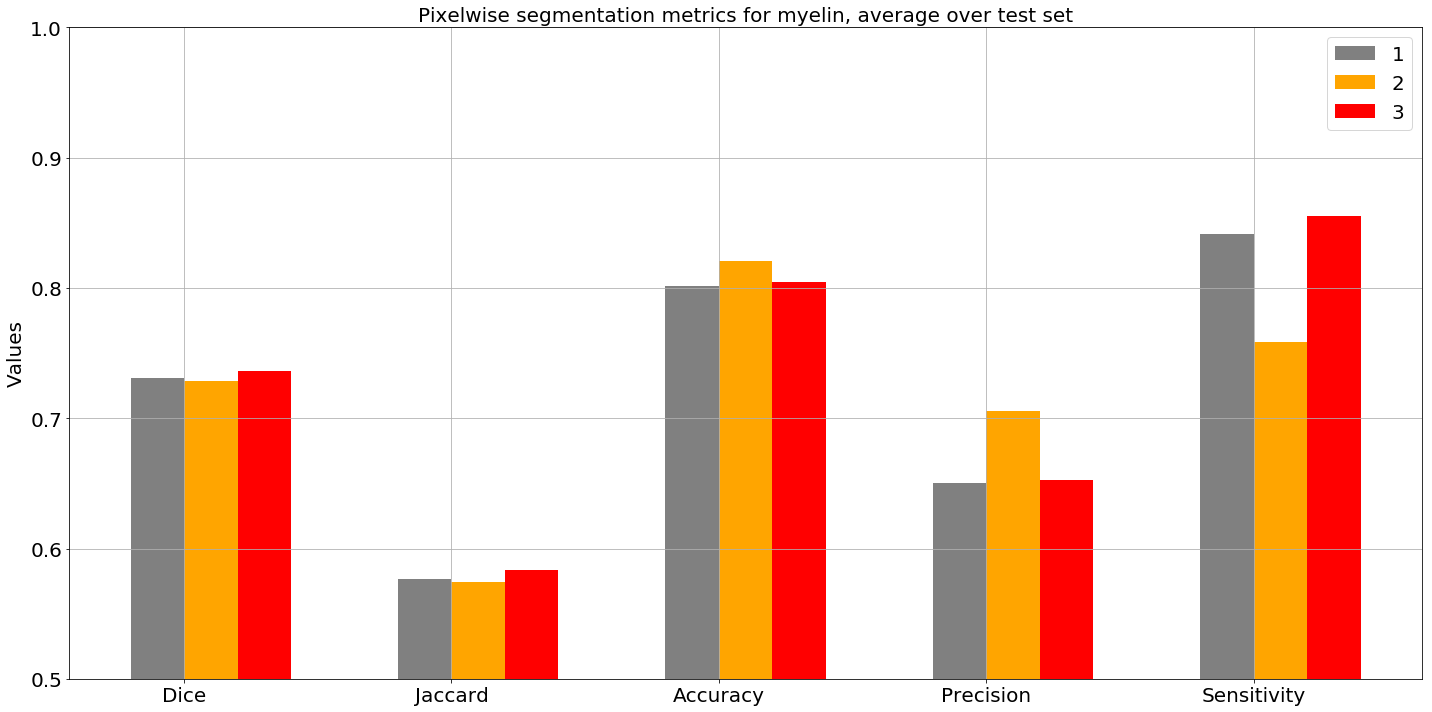

In [204]:
n_groups = 5
width=0.2
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(1, 4, 1):
    plot = np.arange(-0.3, 1.6, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red']
    rects1 = plt.bar(index + plot[i], score_global[i], width=width, color=color[i],label=i)
    

plt.ylabel('Values',fontsize=20)
plt.title('Pixelwise segmentation metrics for myelin, average over test set',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [96]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef


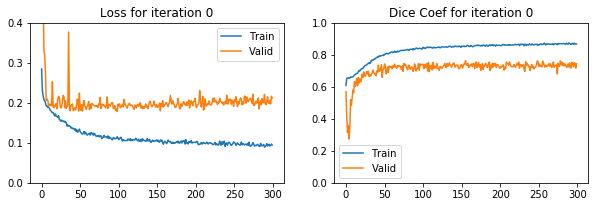

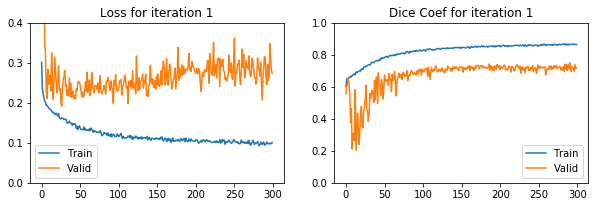

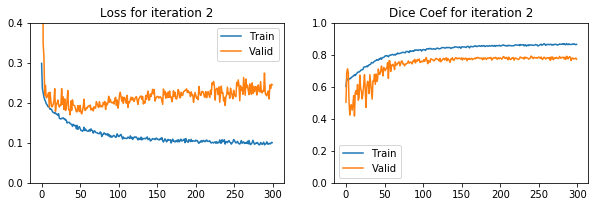

In [143]:
for i  in range(3):
    history_path = ['/home/malub_local/history/0927_1446_40_history_iter_0_.txt', 
                    "/home/malub_local/history/0927_1547_41_history_iter_1_.txt", 
                    "/home/malub_local/history/0927_1640_30_history_iter_2_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(320 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(320 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

## Display segmentation for X_test 

In [208]:
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)

Computing predictions for unlabelled data ...



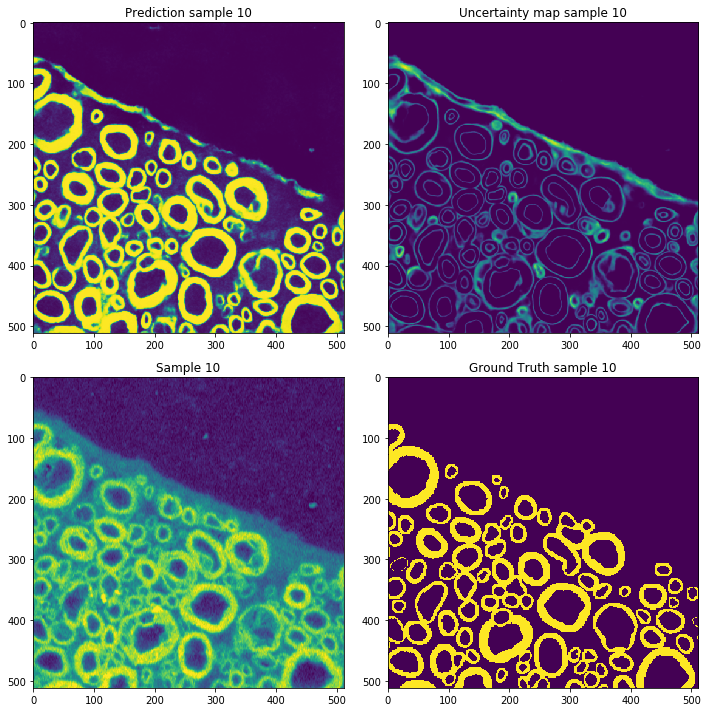

In [231]:
# Plot predictions and uncertainty map for 2 samples 
rand_int = random.randint(0, len(X_test)-1)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[rand_int][0,:,:])
plt.title("Prediction sample " + str(rand_int))
plt.subplot(222)
plt.imshow(uncertain_map[rand_int])
plt.title("Uncertainty map sample "+ str(rand_int))
plt.subplot(223)
plt.imshow(X_test[rand_int][0,:,:])
plt.title("Sample "+ str(rand_int))
plt.subplot(224)
plt.imshow(y_test[rand_int][0,:,:])
plt.title("Ground Truth sample "+ str(rand_int))
plt.tight_layout()
plt.show()

## Choose threshold 

In [190]:
# uncertainty computation
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for threshold in np.arange(0, 1, 0.05):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    dice.append(np.mean(dice_coef_test))


print(len(dice))
print("Done")


Computing log predictions ...

20
Done


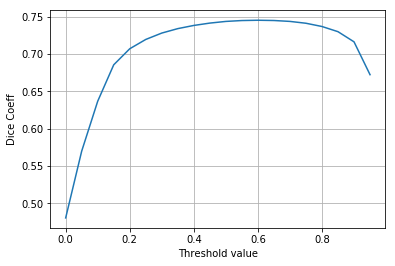

In [147]:
plt.plot(np.arange(0, 1, 0.05), dice )
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.ylabel("Dice Coeff", fontsize = 20)
plt.xlabel("Threshold value", fontsize = 20)
plt.grid()
#plt.ylim(0.7, 0.75)
plt.show()

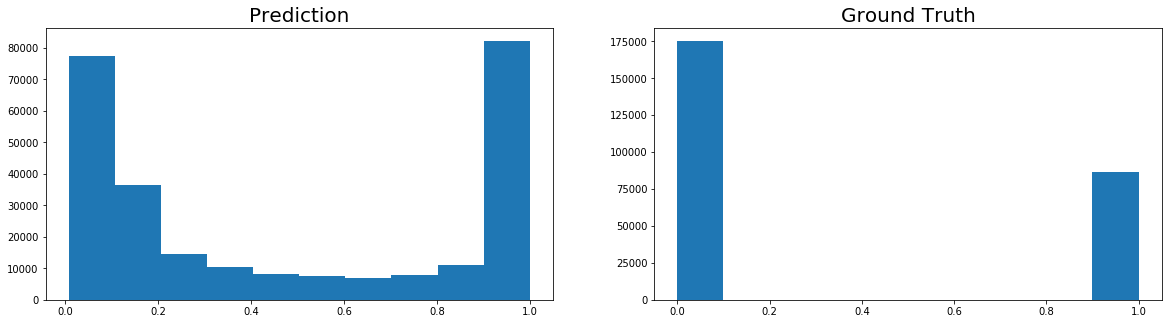

In [203]:
plt.figure(figsize=(20,5))
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.subplot(121)
plt.hist(predictions[0].flatten())
plt.title("Prediction", fontsize = 20)
plt.subplot(122)
plt.hist(y_test[0].flatten())
plt.title("Ground Truth", fontsize = 20)
plt.show()

# Visuaize Data Augmentation

In [ ]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def visualize_data_augmentation(generator):
    batch1 = take(1, generator)
    max_images = 16
    grid_width = 8
    grid_height = 1
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(img, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(mask, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [ ]:
visualize_data_augmentation(train_generator)